In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=5e497f21d20dbb67535031e168d191b3fd1e7e473e2ec65f1d46c53b2ffb71f1
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [4]:
import os
import chess
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
os.chdir('/drive/MyDrive/Colab Notebooks/')
df = pd.read_csv('games_data.csv')
data = df['moves'].tolist()
split_data = []
indice = 500

In [6]:
# Pieces Type Dictionary
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
# Pieces Columns Dictionary
alpha_dict = {
    'a' : [0,0,0,0,0,0,0],
    'b' : [1,0,0,0,0,0,0],
    'c' : [0,1,0,0,0,0,0],
    'd' : [0,0,1,0,0,0,0],
    'e' : [0,0,0,1,0,0,0],
    'f' : [0,0,0,0,1,0,0],
    'g' : [0,0,0,0,0,1,0],
    'h' : [0,0,0,0,0,0,1],
}
# Pieces Rows Dictionary
number_dict = {
    1 : [0,0,0,0,0,0,0],
    2 : [1,0,0,0,0,0,0],
    3 : [0,1,0,0,0,0,0],
    4 : [0,0,1,0,0,0,0],
    5 : [0,0,0,1,0,0,0],
    6 : [0,0,0,0,1,0,0],
    7 : [0,0,0,0,0,1,0],
    8 : [0,0,0,0,0,0,1],
}

In [7]:
# Represent the board as a matrix
def make_matrix(board):
    png = board.epd()
    foo = []
    pieces = png.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        # First Row
        foo2 = []
        for thing in row:
            if thing.isdigit():
                # Append Empty Grids
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                # Append Piece Grid
                foo2.append(thing)
        # Appending First Row
        foo.append(foo2)
    return foo

# Translate chess matrix to [0,1]
def translate(matrix, chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

In [8]:
# Splitting input data into individual moves
for point in data[:indice]:
    point = point.split()    # Split each move string into components
    split_data.append(point) # Append the list of moves to split_data

# List to hold the board states for each move
data = []
for game in split_data:
    board = chess.Board()  # Create a new chess board for each game
    for move in game:
        board_ready = board.copy()  # Copy the current board state
        data.append(board.copy())   # Store the current board state
        board.push_san(move)        # Apply the move to the board

# List to hold the translated board states
trans_data = []
for board in data:
    matrix = make_matrix(board)          # Create a matrix from the board
    trans = translate(matrix,chess_dict) # Translate the matrix
    trans_data.append(trans)             # Append the translated result

# Initialize lists to hold extracted pieces, file (alphas), and ranks (numbers)
pieces = []
alphas = []
numbers = []

In [9]:
# Define a flatten function to flatten a nested list [[1, 2, 3], [4, 5], [6, 7, 8, 9]] -> [1, 2, 3, 4, 5, 6, 7, 8, 9]
def flatten(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

true_data = flatten(split_data)
for i in range(len(true_data)):
    # Try for index out of range error
    try:
        term = flatten(split_data)[i]
        original = term[:]
        term = term.replace('x', '')
        term = term.replace('#', '')
        term = term.replace('+', '')
        if len(term) == 2:
            piece = 'p'
        else:
            piece = term[0]
        alpha = term[-2]
        number = term[-1]
        pieces.append(chess_dict[piece])
        alphas.append(alpha_dict[alpha])
        numbers.append(number_dict[int(number)])
    except:
        pass

In [10]:
# PREDICTING THE PIECE MODEL IT HAS 12 OUTPUTS

# Instantiate a Keras tensor with (8, 8) dimensions for the chess grid and 12 dimension for the number of chess pieces google for more info about the func hah
board_inputs = keras.Input(shape=(8, 8, 12))
# Create a 2D convolutional layer (because 2D board) with 1024 kernels with the size of 3 with the Rectified Linear Unit function
conv1 = layers.Conv2D(1024, 3, activation='relu')
# Create a 2D convolutional layer (because 2D board) with 512 kernels with the size of 3 with the Rectified Linear Unit function
conv2 = layers.Conv2D(512, 3, activation='relu')
# Reduce the spatial dimensions
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
flatten = keras.layers.Flatten(data_format=None)
# Were iterating x as the same input so flatten(conv2(pooling1(conv1(board_inputs))))
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
# Create an output in a form of a dense layer with 12 neurons with the name 'piece' for each piece
piece_output = layers.Dense(12, name='piece')(x)
model_pieces = keras.Model(inputs=board_inputs, outputs=piece_output, name="chess_move_predictor_CNN")
# Early stop when the model is ready
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_pieces.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

# PREDICTING THE ALPHA MODEL(column like 'a', 'b', 'c' ect...) IT HAS 7 OUTPUTS

board_inputs = keras.Input(shape=(8, 8, 12))
conv1 = layers.Conv2D(1024, 3, activation='relu')
conv2 = layers.Conv2D(512, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
alpha_output = layers.Dense(7, name='alpha')(x)
model_alpha = keras.Model(inputs=board_inputs, outputs=alpha_output, name="chess_move_predictor_CNN")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_alpha.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

# PREDICTING THE NUMBER MODEL(row from 1 to 8) IT HAS 7 OUTPUTS

board_inputs = keras.Input(shape=(8, 8, 12))
conv1 = layers.Conv2D(1024, 3, activation='relu')
conv2 = layers.Conv2D(512, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
numbers_output = layers.Dense(7, name='number')(x)
model_number = keras.Model(inputs=board_inputs, outputs=numbers_output, name="chess_move_predictor_CNN")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_number.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

Epoch 1/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2199 - loss: 0.0765
Epoch 2/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2641 - loss: 0.0675
Epoch 3/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3161 - loss: 0.0651
Epoch 4/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3558 - loss: 0.0628
Epoch 5/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3880 - loss: 0.0608
Epoch 6/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4197 - loss: 0.0587
Epoch 7/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4497 - loss: 0.0567
Epoch 8/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4753 - loss: 0.0547
Epoch 9/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5082 - loss: 0.0529
Epoch 10/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5323 - loss: 0.0508
Epoch 11/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5470 - loss: 0.0494
Epoch 12/100
427/427 ━━━━━━━━━━━━━━━━━━━

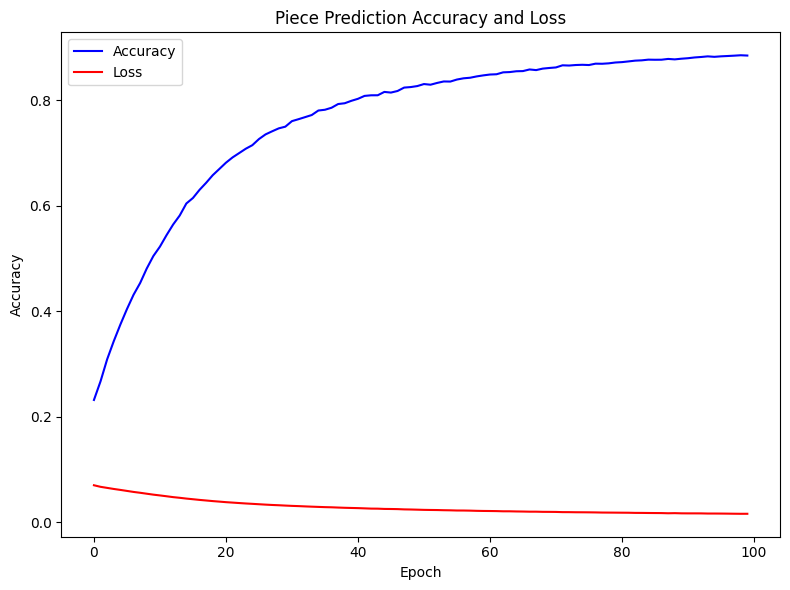

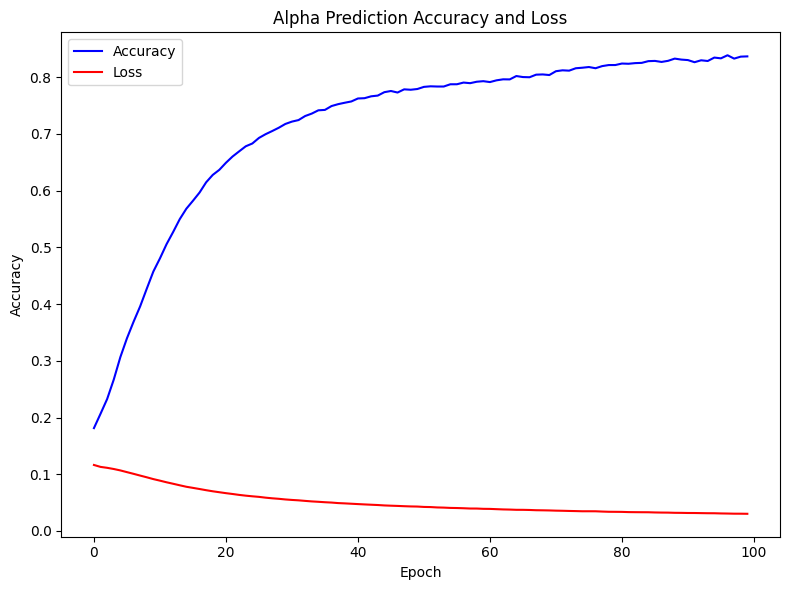

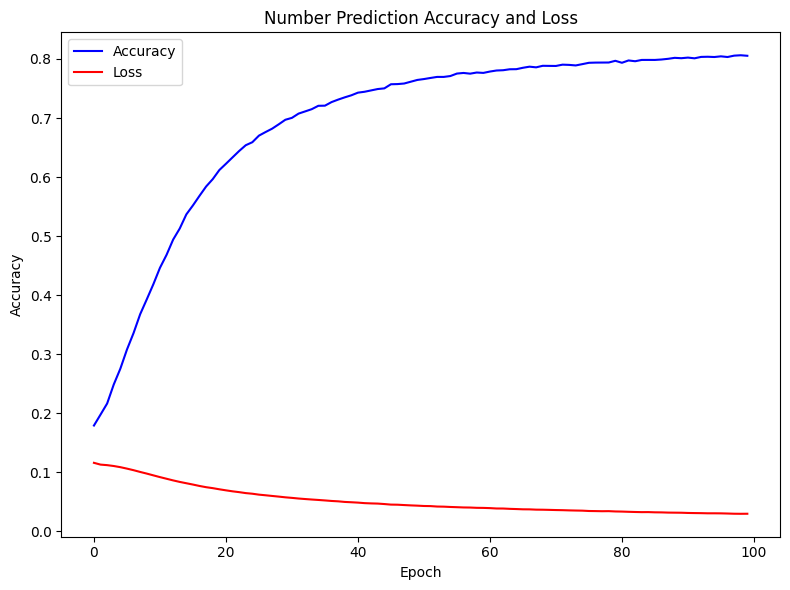

In [11]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history, title):
    plt.figure(figsize=(8, 6))

    # Plot Accuracy
    plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
    plt.title(f'{title} Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot Loss on the same graph
    plt.plot(history.history['loss'], label='Loss', color='red')
    plt.legend()

    plt.tight_layout()

# Training history for piece prediction model
piece_history = model_pieces.fit(
    np.array(trans_data[:len(pieces)]),
    np.array(pieces[:len(pieces)]),
    batch_size=64,
    epochs=100,
    callbacks=[earlystop],
)

# Training history for alpha prediction model
alpha_history = model_alpha.fit(
    np.array(trans_data[:len(alphas)]),
    np.array(alphas[:len(alphas)]),
    batch_size=64,
    epochs=100,
    callbacks=[earlystop],
)

# Training history for number prediction model
number_history = model_number.fit(
    np.array(trans_data[:len(numbers)]),
    np.array(numbers[:len(numbers)]),
    batch_size=64,
    epochs=100,
    callbacks=[earlystop],
)

# Plot accuracy and loss graphs for each model
plot_accuracy_loss(piece_history, 'Piece Prediction')
plt.show()

plot_accuracy_loss(alpha_history, 'Alpha Prediction')
plt.show()

plot_accuracy_loss(number_history, 'Number Prediction')
plt.show()

In [12]:
# Initialize new dictionaries for chess terms, alphabets, and numbers
new_chess_dict = {}
new_alpha_dict = {}
new_number_dict = {}

# Create a bi-directional mapping for chess terms
#    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
#    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
#    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
#    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
#    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
#    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
#    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
#    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
#    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
#    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
#    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
#    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
#    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
for term in chess_dict:
    # Convert the definition to a tuple
    definition = tuple(chess_dict[term])
    # Map definition to term
    new_chess_dict[definition] = term
    # Map term to definition
    new_chess_dict[term] = definition

# Create a bi-directional mapping for alpha terms
#    'a' : [0,0,0,0,0,0,0],
#    'b' : [1,0,0,0,0,0,0],
#    'c' : [0,1,0,0,0,0,0],
#    'd' : [0,0,1,0,0,0,0],
#    'e' : [0,0,0,1,0,0,0],
#    'f' : [0,0,0,0,1,0,0],
#    'g' : [0,0,0,0,0,1,0],
#    'h' : [0,0,0,0,0,0,1],
for term in alpha_dict:
    # Convert the definition to a tuple
    definition = tuple(alpha_dict[term])
    # Map definition to term
    new_alpha_dict[definition] = term
    # Map term to definition
    new_alpha_dict[term] = definition

# Create a bi-directional mapping for number terms
#    1 : [0,0,0,0,0,0,0],
#    2 : [1,0,0,0,0,0,0],
#    3 : [0,1,0,0,0,0,0],
#    4 : [0,0,1,0,0,0,0],
#    5 : [0,0,0,1,0,0,0],
#    6 : [0,0,0,0,1,0,0],
#    7 : [0,0,0,0,0,1,0],
#    8 : [0,0,0,0,0,0,1],
for term in number_dict:
    # Convert the definition to a tuple
    definition = tuple(number_dict[term])
    # Map definition to term
    new_number_dict[definition] = term
    # Map term to definition
    new_number_dict[term] = definition

# Reshape the input data for the model to fit the expected input shape (1 batch, 8x8 grid, 12 channels)
data = np.reshape(trans_data[0], (1, 8, 8, 12))

# Make predictions for the chess piece, alphabet, and number using their respective models
pred = model_pieces.predict(data)

# Function to translate model predictions into a one-hot encoded format
def translate_pred(pred):
    # Initialize an array to hold the translation
    translation = np.zeros(pred.shape)
    # Get the index of the highest prediction value
    index = pred[0].tolist().index(max(pred[0]))
    # Set the corresponding index in translation to 1 (one-hot encoding)
    translation[0][index] = 1
    return translation[0]

# Translate predictions for the chess piece, alphabet, and number
piece = translate_pred(model_pieces.predict(data))
alpha = translate_pred(model_alpha.predict(data))
number = translate_pred(model_number.predict(data))

# Retrieve the corresponding terms from the dictionaries using the predicted one-hot encoded tuples
piece_pred = new_chess_dict[tuple(piece)]
alpha_pred = new_alpha_dict[tuple(alpha)]
number_pred = new_number_dict[tuple(number)]

# Construct the final move string by concatenating the predicted terms
move = str(piece_pred) + str(alpha_pred) + str(number_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


In [13]:
# Assuming you've already trained your models and assigned them to variables
model_pieces.save('/drive/MyDrive/Colab Notebooks/piece_model.h5')
model_alpha.save('/drive/MyDrive/Colab Notebooks/alpha_model.h5')
model_number.save('/drive/MyDrive/Colab Notebooks/number_model.h5')

In [14]:
import chess
import numpy as np
from tensorflow import keras

# Load the trained models (you need to load the correct weights and architecture)
piece_model = keras.models.load_model('/drive/MyDrive/Colab Notebooks/piece_model.h5')
alpha_model = keras.models.load_model('/drive/MyDrive/Colab Notebooks/alpha_model.h5')
number_model = keras.models.load_model('/drive/MyDrive/Colab Notebooks/number_model.h5')

# Define a dictionary to map piece class indices to their corresponding FEN representations
piece_dict = {0: 'p', 1: 'r', 2: 'n', 3: 'b', 4: 'q', 5: 'k', 6: 'P', 7: 'R', 8: 'N', 9: 'B', 10: 'Q', 11: 'K'}

# Define a function to preprocess the board
def preprocess_board(board):
    matrix = make_matrix(board)
    encoded_board = translate(matrix, chess_dict)
    return np.expand_dims(encoded_board, axis=0)

# Define a function to predict the best move from a FEN string
def predict_best_move(fen_board):
    board = chess.Board(fen_board)

    # Initialize variables to keep track of the best move and its probability
    best_move = None
    best_move_probability = -1.0  # Set to a low value

    # Iterate through all legal moves and predict their probabilities
    for move in board.legal_moves:
        board.push(move)
        input_data = preprocess_board(board)

        predicted_piece = piece_model.predict(input_data)
        predicted_alpha = alpha_model.predict(input_data)
        predicted_number = number_model.predict(input_data)

        # Convert predicted values to strings for comparison
        piece_idx = np.argmax(predicted_piece)
        alpha_idx = np.argmax(predicted_alpha)
        number_idx = np.argmax(predicted_number)

        predicted_move = f"{chess.SQUARE_NAMES[move.from_square]}{chess.SQUARE_NAMES[move.to_square]}"

        # Calculate a move score based on your criteria (e.g., piece type, alpha, number)
        move_score = predicted_piece[0][piece_idx] + predicted_alpha[0][alpha_idx] + predicted_number[0][number_idx]

        if move_score > best_move_probability:
            best_move = predicted_move
            best_move_probability = move_score

        # Undo the move to consider the next legal move
        board.pop()

    return best_move


fen_board = 'r1bqkbnr/ppp2ppp/2n5/3Bp3/4P3/5Q2/PPPP1PPP/RNB1K1NR b KQkq - 0 1'
best_move = predict_best_move(fen_board)
print("Best next move:", best_move)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━